In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it
import missingno as msno
import utils
import numpy as np
from os import path

#DATASET_PATH='../dataset/races.csv'

DATASET_PATH=path.join('..','dataset','races.csv')
races_df=pd.read_csv(DATASET_PATH,
                     parse_dates=['date'],
                     #dtype=RACES_DTYPES
                     )
races_df['delta']=pd.to_timedelta(races_df['delta'],'seconds',errors='ignore')

/tmp/ipykernel_32484/4155322922.py:16: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_timedelta without passing `errors` and catch exceptions explicitly instead
  races_df['delta']=pd.to_timedelta(races_df['delta'],'seconds',errors='ignore')


In [6]:
races_df.head()

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
0,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,0,sean-kelly,22.0,True,False,False,vini-ricordi-pinarello-sidermec-1986,0 days
1,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,1,gerrie-knetemann,27.0,True,False,False,norway-1987,0 days
2,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,2,rene-bittinger,24.0,True,False,False,NaN,0 days
3,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,3,joseph-bruyere,30.0,True,False,False,navigare-blue-storm-1993,0 days
4,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,4,sven-ake-nilsson,27.0,True,False,False,spain-1991,0 days


# Cyclists data quality analysis

This notebook takes care of the data quality assessment for the cyclists data.

## dataset description
First we need to describe the dataset and the meaning of it's values to understand the analysis.

We have a tabular dataset composed by the following features:
- _url: unique identifier, it is composed of a string mad by the name of the races,the year and the stage, it is coded with a string.
- name: name of the race, coded with a string.
- points: pointss assigned to the race, coded with an integer in the range $[0,+\infty)$.
- uci_points: alternative points assigned to the race,coded with an integer in the range $[0,+\infty)$.
- length: total meters length of the race, coded with a floating point value in the range $[0,+\infty)$.
- climb_total: total meters climbed during the race,coded with a floating point value in the range $[0,+\infty)$.
- profile: the profile of the race, coded with integer values in the range \[1,2,3,4,5\].
- starlist_quality: quality of the participant, coded with an integer in the range $[0,+\infty)$.
- average_temperature: average temperature in celsius, coded with a float in the range $(-\infty,+\infty)$.
- position: position of the participant for that stage, coded with an integer in the range $[0,+\infty)$.
- cyclist: cyclist identifier, coded with a string.
- is_tarmac: boolean flag identifying the terrain is tarmac or not, coded with a boolean.
- is_cobbled: boolean flag identifying the terrain is tarmac or not, coded with a boolean.
- is_gravel: boolean flag identifying the terrain is tarmac or not, coded with a boolean.
- cyclist_team: team of the cyclist, coded with a string.
- date: date the race took place, coded using the datetime data type.
- delta: it's difference between the first person to arrive and the participant coded using the deltatime datatype, the value is expected to be non-negative.

## preliminary analysis

A first dumb check evidences no duplicate rows (at least across all features).

In [7]:
len(races_df[races_df.duplicated()])

0

A first preliminary analysis we can show how many values are currently missing from the dataset.

In [2]:
mv_df=pd.DataFrame(races_df.isnull().sum())
mv_df=mv_df.rename(columns={0:'missing values'})
mv_df['missing values']=mv_df['missing values'].astype('int')
mv_df['missing values %']=((mv_df['missing values']/len(races_df))*100).round(3)
mv_df.sort_values('missing values',ascending=False)

mv_cols=list(mv_df[mv_df['missing values'] > 0].index)
mv_cols.append('date')

mv_df

,missing values,missing values %
_url,0,0.000
name,0,0.000
points,477,0.081
uci_points,338779,57.433
length,0,0.000
climb_total,147045,24.929
profile,148194,25.123
startlist_quality,0,0.000
average_temperature,559932,94.925
date,0,0.000


The most missing features are the average temperature with almost all values missing, uci_points has more than half of it values missing and we also have the cyclist_team,profile and climb_total have around 25% of their values missing.
For all the other attributes the missing values are very few or none at all.

We can obtain a better visualization through a bar plot:

/home/mirdan08/DataMiningProject/src/task1_data_understanding/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  values['all other features'] = 0


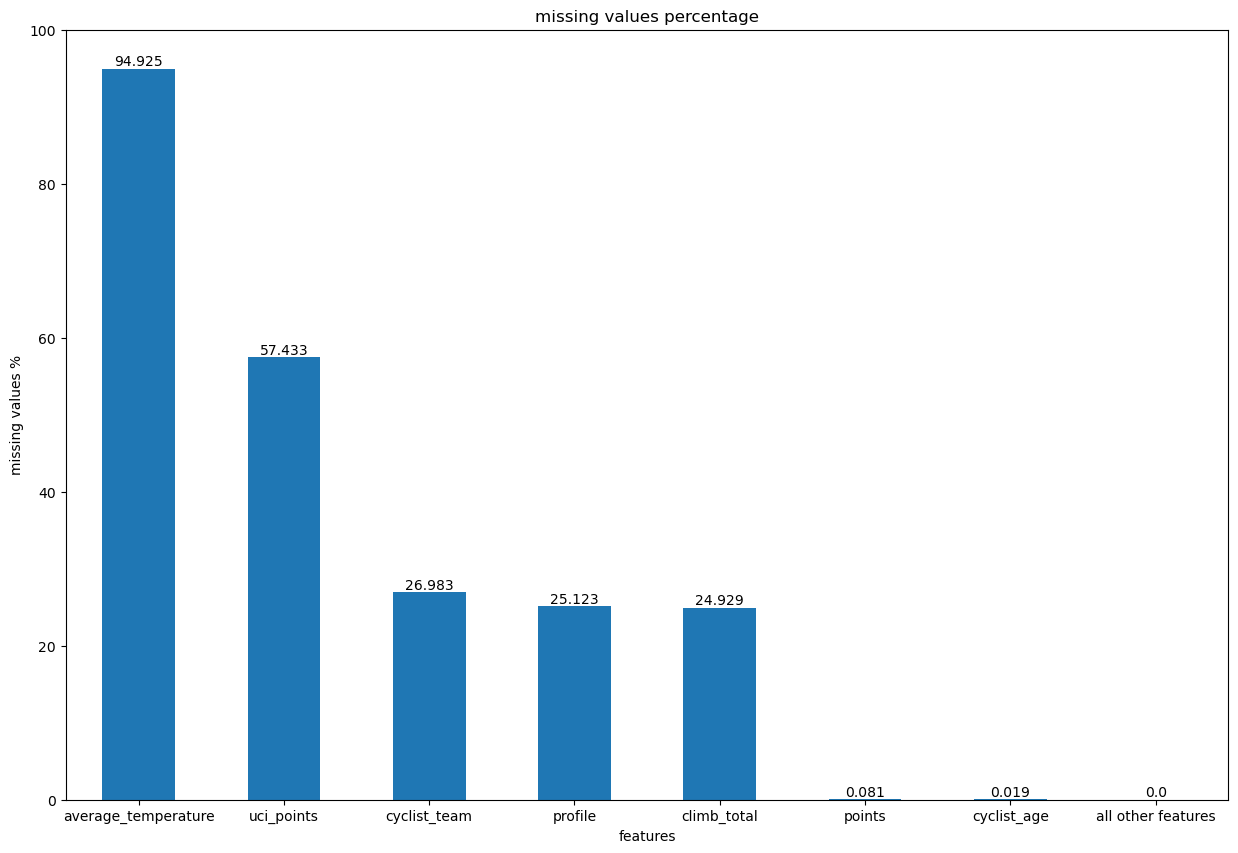

In [9]:
utils.plot_missing_values_barplot(mv_df)

# features in-domain analysis
We can do a first analysis on single features taking care of possible missing values,out-of-domain values or default values.
We can start with the analysis of the first two values.

## `_url` and `name`


The first attribute is redundant and contains duplicate information with no wrong or missing values w.r.t. to its duplicates, below we can see that the name of the race is correct and same goes for the year for each entry in the dataset.

Note: checking the name in `_url` to match the `name` feature is useless since the name attribute in the orginal dataset contains different values for the same races and cannot be confronted with the name contained in the `_url` attribute, but the name contained in _url is useful as it is standardized and avoids ambiguity.

In [5]:
# the feature has useful information to be used further in the analysis
url_df=races_df['_url'].str.split('/',expand=True)
url_df.rename(columns={0:'name',1:'year',2:'stage'},inplace=True)
url_df['original_name']=races_df['name']
url_df['original_year']=races_df['date'].dt.year.astype('int32')
url_df['year']=url_df['year'].astype('int32')
correct_years=len(url_df[url_df['original_year']==url_df['year']])
print(len(url_df)-correct_years)

0


## numerical values analysis

this part analises all the various numerical attributes checking if their non missing values are within their domain.

In [11]:
points=races_df['points'].dropna()
print('values lower than 0:',len(points[points<0]))

values lower than 0: 0


In [12]:
uci_points=races_df['uci_points'].dropna()
print('values lower than 0:',len(uci_points[uci_points<0]))

values lower than 0: 0


In [13]:
length=races_df['length'].dropna()
print('values lower than 0:',len(length[length<=0]))

values lower than 0: 0


In [14]:
climb_total=races_df['climb_total'].dropna()
print('values lower than 0:',len(climb_total[climb_total<=0]))

values lower than 0: 0


In [15]:
startlist_quality=races_df['startlist_quality'].dropna()
print('values lower than or equal to 0:',len(startlist_quality[startlist_quality<=0]))

values lower than or equal to 0: 0


In [16]:
average_temperature=races_df['average_temperature'].dropna()
print('average temperature values range',average_temperature.min(),"to",average_temperature.max())

average temperature values range 10.0 to 36.0


In [17]:
position=races_df['position'].dropna()
print('values lower than 0:',len(position[position<0]))

values lower than 0: 0


In [18]:
cyclist_age=races_df['cyclist_age'].dropna()
print('values lower than 0:',cyclist_age.min(),cyclist_age.max())

values lower than 0: 13.0 56.0


In [19]:
delta=races_df['delta'].dropna()
print('values lower than 0:',len(delta[delta<pd.Timedelta(0)]))

values lower than 0: 86


From these we can infer that all numerical values have correct values within range except for delta which has some values that are not.
## date analysis

We can continue with other kind of attributes, first the dates.

In [20]:
dates=races_df['date'].dropna()
print(dates.min(),dates.max())

1970-02-28 04:52:00 2023-07-29 05:52:14


The dates are all within a sensed range.

## profile analysis

We can now analise the profile for the races which is coded as integers in the range \[1,2,3,4,5\].

In [21]:
profile=races_df['profile'].dropna()
# values are coded with integers from 1 to 5
domain_values=[1,2,3,4,5]
print('out of range values :',len(profile[~profile.isin(domain_values)]))

out of range values : 0


Also here we don't have any range issues.

## is_X analysis

As for the is_X values we should have at least one flag True for each row

([<matplotlib.patches.Wedge at 0x7f88d9a74440>,
 [Text(-1.055113366015054, 0.3110237689572657, 'at least one flag'),
  Text(1.0551133587350172, -0.3110237936539762, 'no flags')],
 [Text(-0.5755163814627567, 0.1696493285221449, '90.88'),
  Text(0.5755163774918275, -0.1696493419930779, '9.12')])

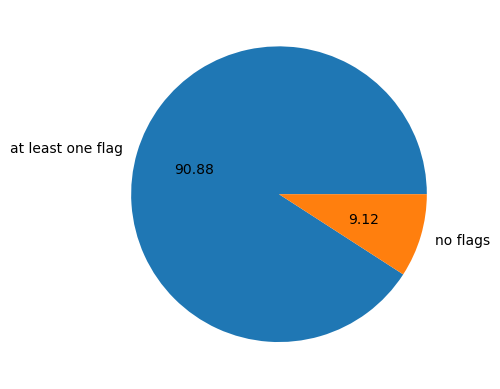

In [22]:
is_X_df=races_df[['is_tarmac','is_cobbled','is_gravel']]
is_X_value=is_X_df.sum(axis=1).value_counts().values

plt.pie(x=is_X_value,
        labels=[
                f'at least one flag',
                f'no flags'
        ] ,
        autopct='%1.2f',
        )

But as we can see that is not true, it should be determined if the terrain can be another type or is just missing the values.

# races names

We can now analize the names of the races.

In [23]:
names=races_df['name'].unique()
names.sort()
names,len(names)

(array(['Amstel Gold Race', 'Clasica Ciclista San Sebastian',
        'Clásica Ciclista San Sebastian', 'Clásica Ciclista San Sebastián',
        'Clásica San Sebastián', 'Criterium du Dauphiné',
        'Criterium du Dauphiné Libére', 'Critérium du Dauphiné',
        'Critérium du Dauphiné Libéré', 'Donostia San Sebastian Klasikoa',
        'Dwars door België / À travers la Belgique',
        'Dwars door Vlaanderen',
        'Dwars door Vlaanderen - A travers la Flandre ME',
        'Dwars door Vlaanderen / A travers la Flandre',
        'Dwars door Vlaanderen / A travers la Flandre ME',
        'E3 BinckBank Classic', 'E3 Harelbeke', 'E3 Prijs Vlaanderen',
        'E3 Prijs Vlaanderen - Harelbeke', 'E3 Saxo Bank Classic',
        'E3 Saxo Classic', 'E3-Prijs Harelbeke', "Giro d'Italia",
        'Giro di Lombardia', 'Gran Camiño',
        'Grand Prix Cycliste de Montréal', 'Grand Prix Cycliste de Quebec',
        'Grand Prix Cycliste de Québec', 'Il Lombardia',
        'Itzulia Basque

By observing the output we can see that some races have duplicate names with some syntax errors, so we could have duplicates or have different races for some of them i.e. they are the same race with different name or a different race at all.

In [24]:
normalized_names={utils.normalize_text(name) for name in names}
normalized_names,len(normalized_names)

({'amstel gold race',
  'clasica ciclista san sebastian',
  'clasica san sebastian',
  'criterium du dauphine',
  'criterium du dauphine libere',
  'donostia san sebastian klasikoa',
  'dwars door belgie  a travers la belgique',
  'dwars door vlaanderen',
  'dwars door vlaanderen  a travers la flandre',
  'dwars door vlaanderen  a travers la flandre me',
  'e3 binckbank classic',
  'e3 harelbeke',
  'e3 prijs vlaanderen',
  'e3 prijs vlaanderen  harelbeke',
  'e3 saxo bank classic',
  'e3 saxo classic',
  'e3prijs harelbeke',
  'giro di lombardia',
  'giro ditalia',
  'gran camino',
  'grand prix cycliste de montreal',
  'grand prix cycliste de quebec',
  'il lombardia',
  'itzulia basque country',
  'la fleche wallonne',
  'la vuelta ciclista a espana',
  'liege  bastogne  liege',
  'liegebastogneliege',
  'milanosanremo',
  'monte paschi eroica',
  'montepaschi strade bianche  eroica toscana',
  'o gran camino',
  'omloop het nieuwsblad me',
  'omloop het volk',
  'omloop het volk me

As we can see even after some normalization getting useful information is still difficult, this difficulty can be workaround using the information contained in the _url attribute which has normalized values and doesn't contain in ambiguity.

An interesting observation is that races ocur multiple times with different names sometimes we can also have some innsight on the category e.g. ME=Men Elite for tour de france, it is to be determined wether we are still talking about thesame race but in different categories across different years.

## missing values matrix across time

We've seen until now just the single missing values, to understand better our dataset we can correlate missing values with time to see any meaningful pattern.

[1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
date
1970         0
1971       623
1972      1099
1973      1376
1974      1613
1975      1835
1976      2446
1977      3068
1978      4136
1979      6754
1980      9697
1981     14544
1982     19998
1983     24388
1984     29556
1985     35766
1986     41848
1987     47026
1988     52673
1989     57817
1990     63147
1991     68813
1992     75001
1993     80698
1994     88733
1995     94744
1996    100369
1997    112265
1998    124112
1999    136005
2000    151988
2001    167669
2002    185225
2003    203037
2004    219217
2005    235923
2006    255015
2007    271119
2008    290176
2009    308610
2010    326571
2011    345471
2012    365231
2013    385270
2014    40

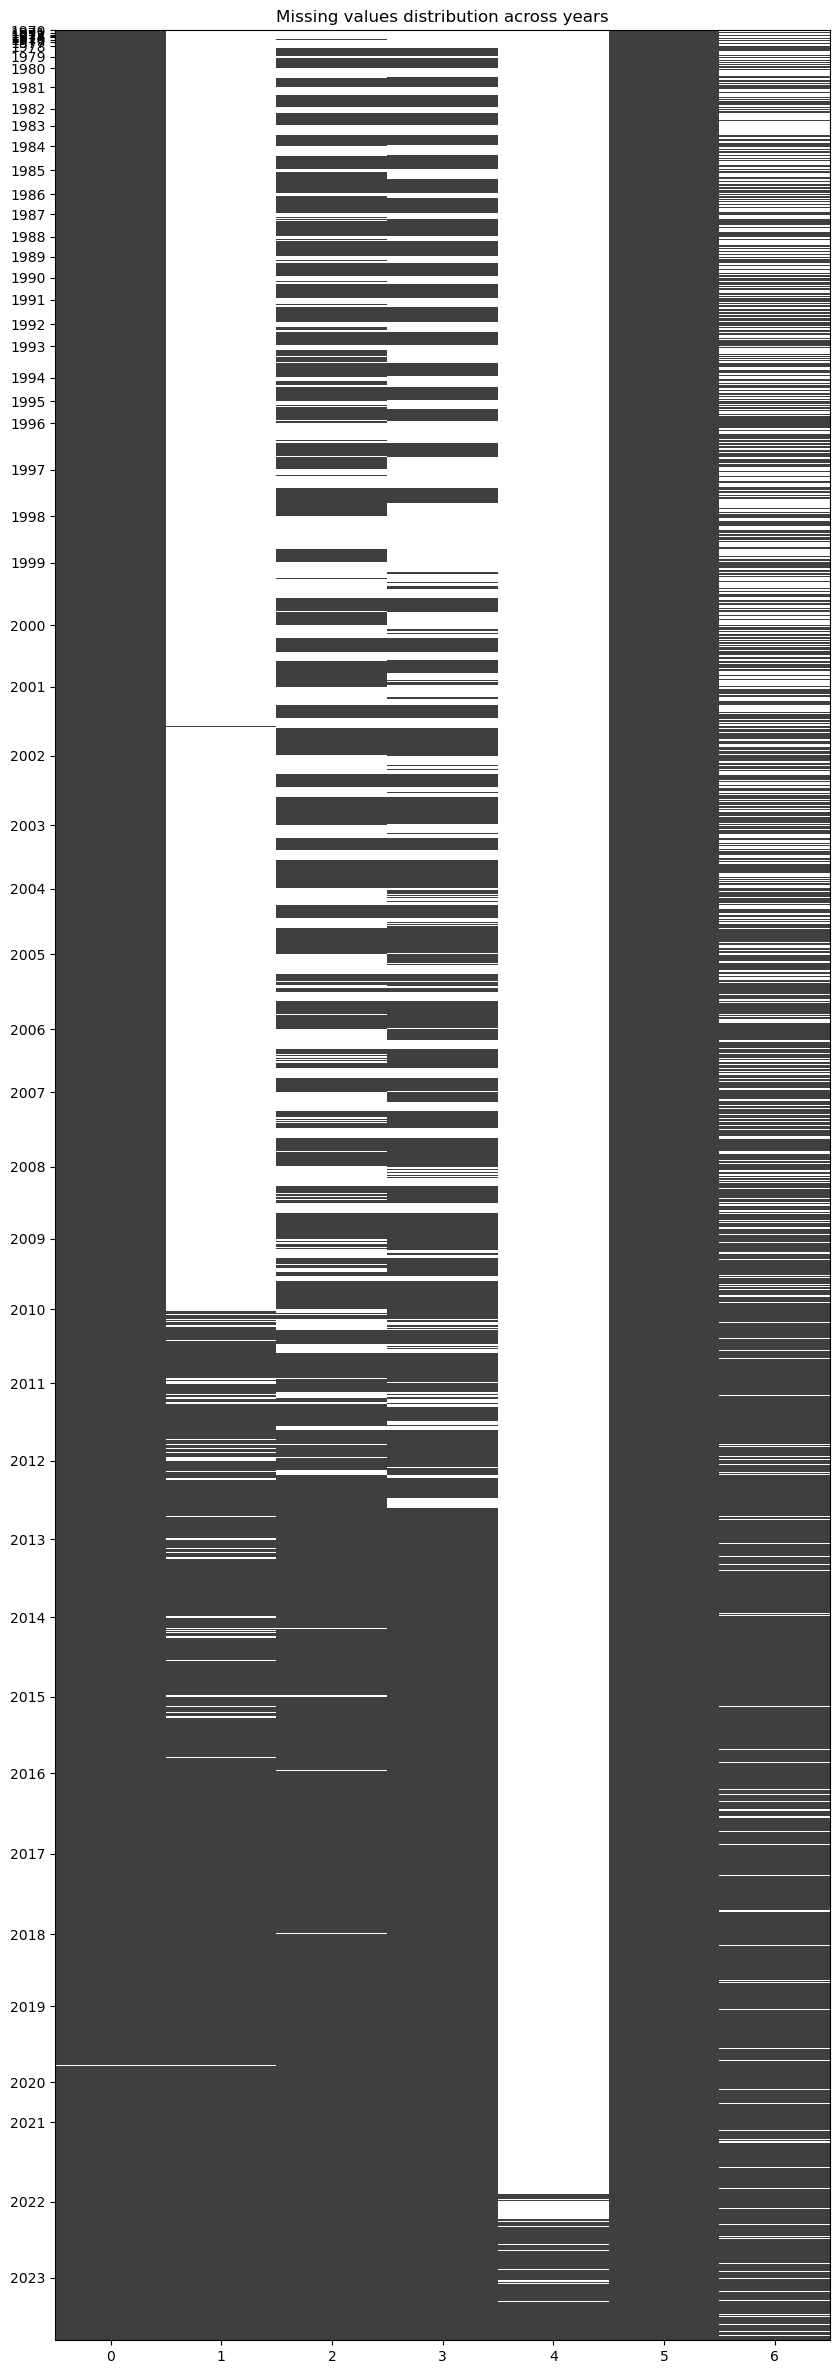

In [3]:
utils.plot_msno_matrix(races_df[mv_cols])

As we can see uci_points are missing until 2000 while the average temperature is missing until 2020. Also climb_total and profile have some gaps until 2004 where they stop missing entirely while cyclist_team has some missing values across all the years with a concentration on years before 1998.

## missing values correlation heatmap

Observing the plot above we can see that profile and climb total seem to be highly correlated and both are present or missing together, this can be proved by plotting a missing values correlation map below.

<Axes: >

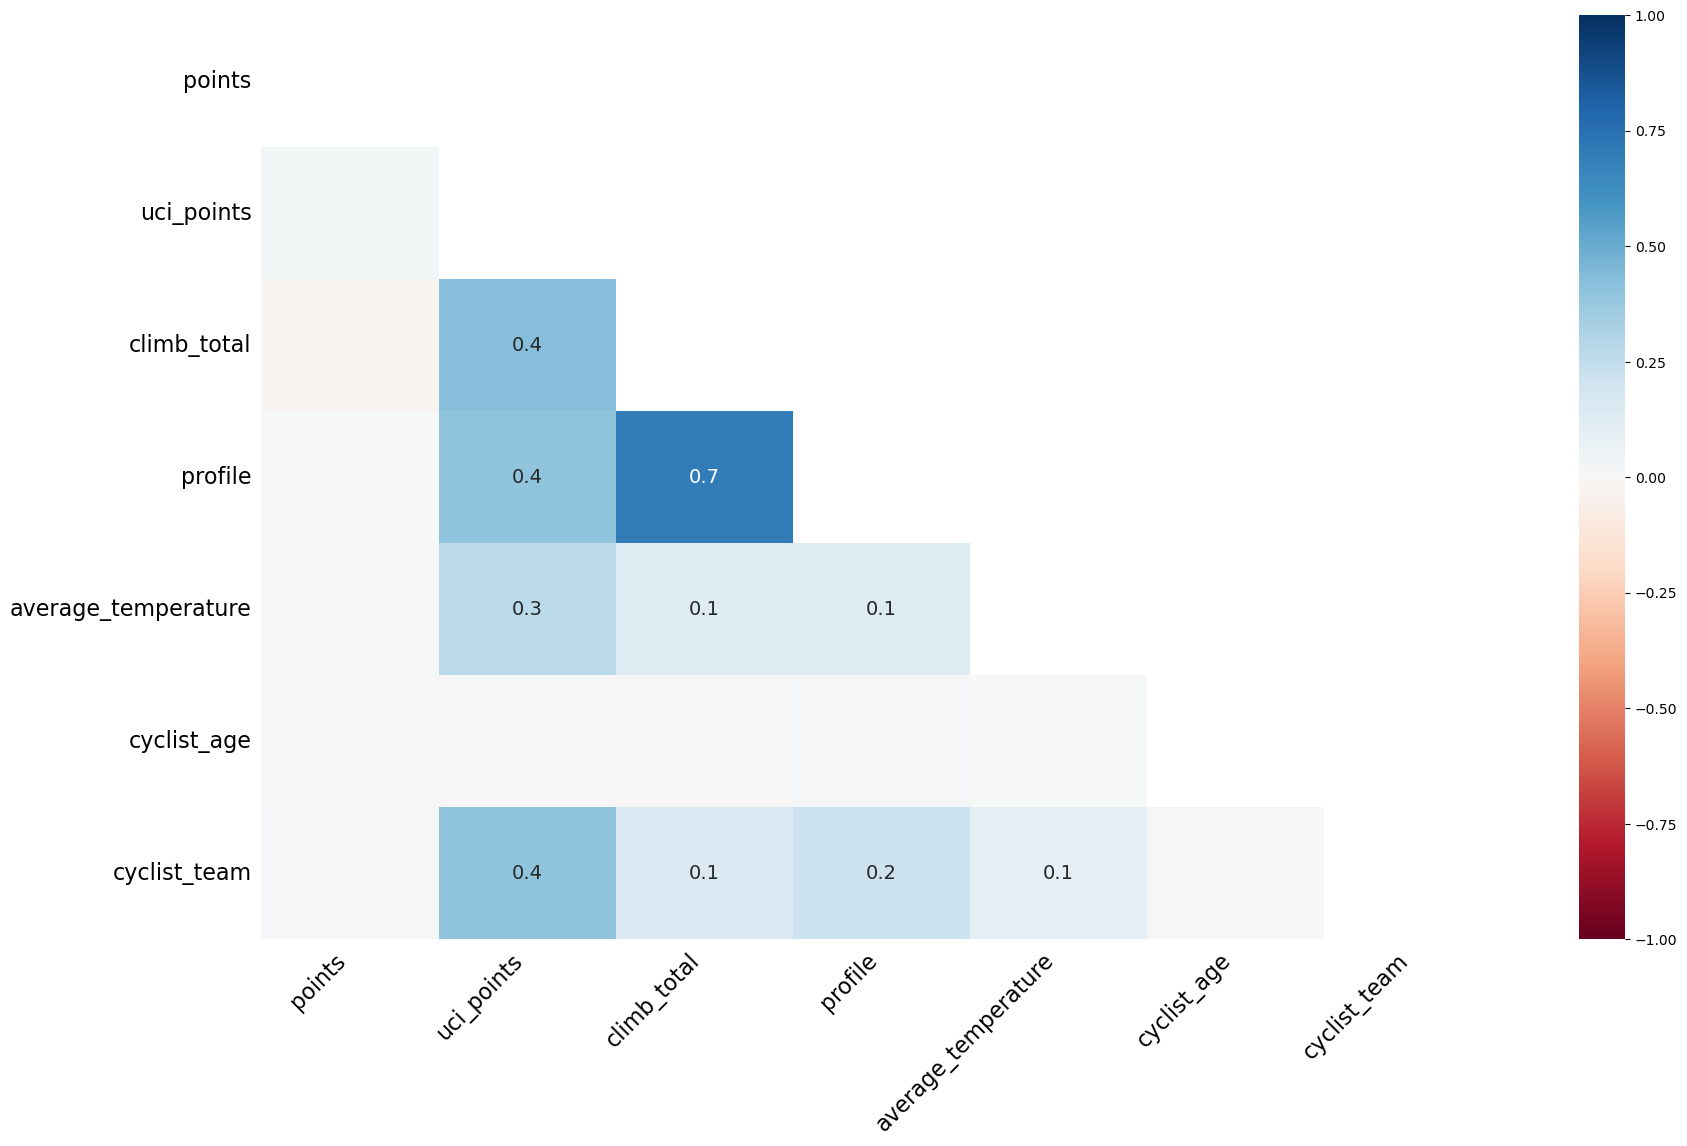

In [ ]:
msno.heatmap(races_df)

# missing values per race

Finally another interesting insight is the missing values per race.

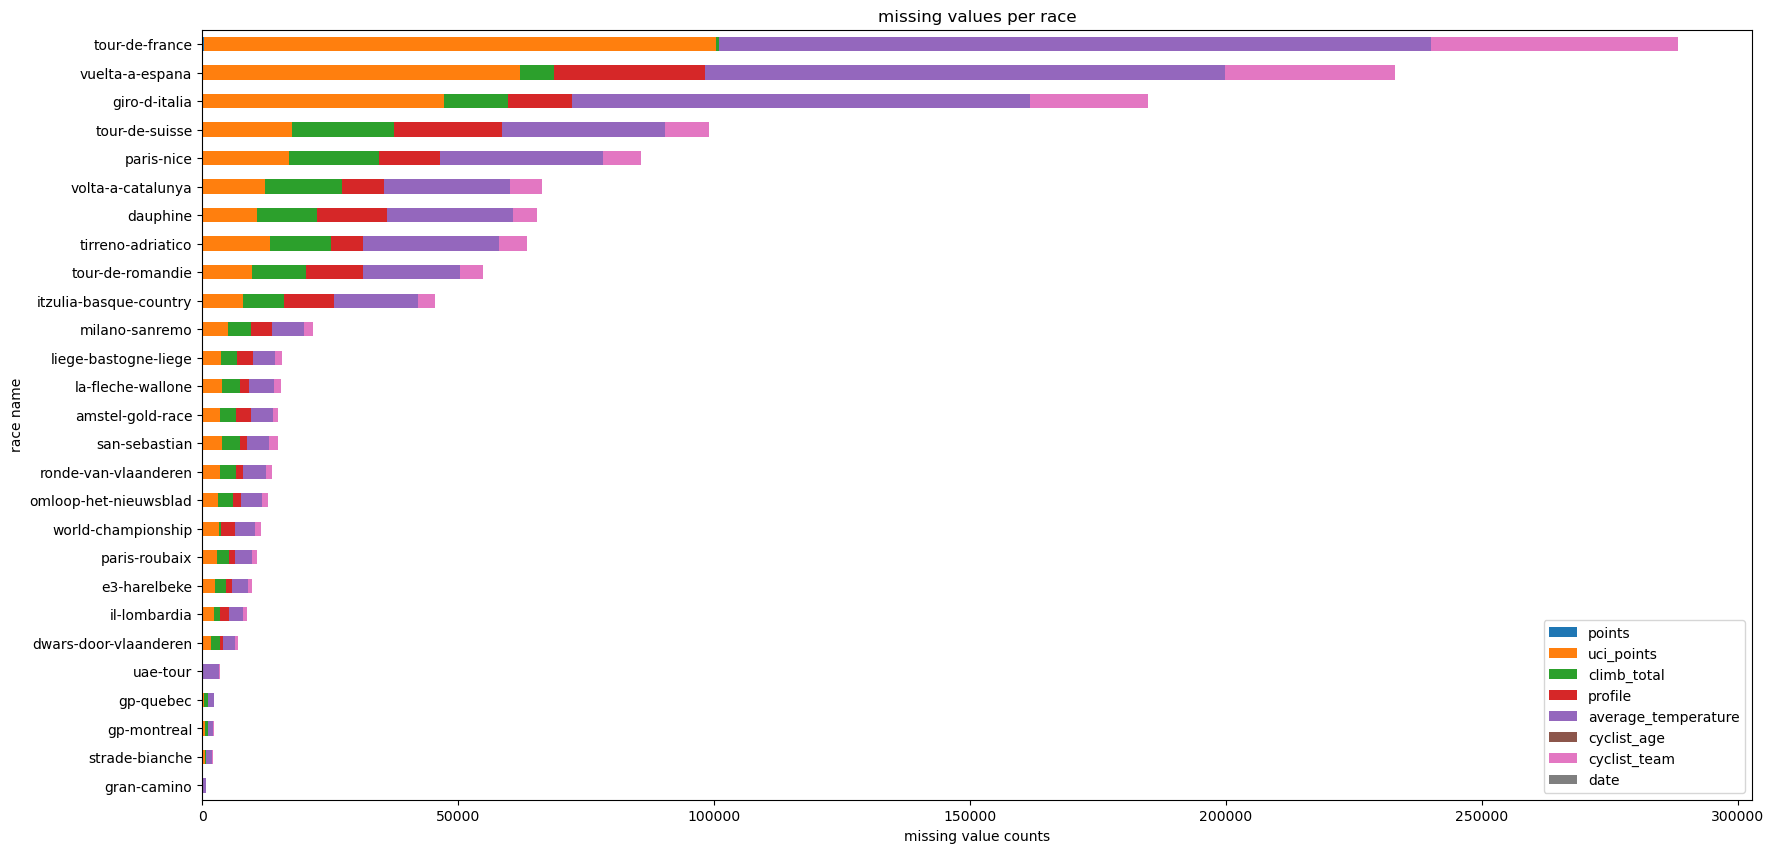

In [ ]:
utils.plot_races_mv(races_df,url_df,mv_cols)

As we can see the most missing value, as to be expected, is the average temperature along with uci_points.

In [ ]:
import re


races_df_ext=races_df.copy()

races_df_ext['std_name']=url_df['name']
#parse the value format for the stage
races_df_ext['stage']=url_df['stage'].str.split('-',expand=True)[1]
#if Non is a value then the split is useless, restore the old value
races_df_ext.loc[url_df['stage']=='prologue','stage']='prologue'
races_df_ext.loc[url_df['stage']=='result','stage']='result'
races_df_ext

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,...,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta,url_name,std_name,stage
0,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,...,sean-kelly,22.0,True,False,False,vini-ricordi-pinarello-sidermec-1986,0 days 00:00:00,tour-de-france,tour-de-france,6
1,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,...,gerrie-knetemann,27.0,True,False,False,norway-1987,0 days 00:00:00,tour-de-france,tour-de-france,6
2,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,...,rene-bittinger,24.0,True,False,False,NaN,0 days 00:00:00,tour-de-france,tour-de-france,6
3,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,...,joseph-bruyere,30.0,True,False,False,navigare-blue-storm-1993,0 days 00:00:00,tour-de-france,tour-de-france,6
4,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,...,sven-ake-nilsson,27.0,True,False,False,spain-1991,0 days 00:00:00,tour-de-france,tour-de-france,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589860,giro-d-italia/2010/stage-1,Giro d'Italia,80.0,16.0,8400.0,60.0,1.0,878,NaN,2010-05-08 00:11:38,...,anders-lund-1,25.0,True,False,False,watney-avia-1972,0 days 00:01:20,giro-d-italia,giro-d-italia,1
589861,giro-d-italia/2010/stage-1,Giro d'Italia,80.0,16.0,8400.0,60.0,1.0,878,NaN,2010-05-08 00:11:40,...,andrea-masciarelli,28.0,True,False,False,NaN,0 days 00:01:22,giro-d-italia,giro-d-italia,1
589862,giro-d-italia/2010/stage-1,Giro d'Italia,80.0,16.0,8400.0,60.0,1.0,878,NaN,2010-05-08 00:11:41,...,marco-corti,24.0,True,False,False,kazakhstan-2001,0 days 00:01:23,giro-d-italia,giro-d-italia,1
589863,giro-d-italia/2010/stage-1,Giro d'Italia,80.0,16.0,8400.0,60.0,1.0,878,NaN,2010-05-08 00:11:48,...,robbie-mcewen,38.0,True,False,False,radio-popular-paredes-boavista-2023,0 days 00:01:30,giro-d-italia,giro-d-italia,1


In [ ]:
set(races_df_ext['stage'])

{'0',
 '1',
 '10',
 '10a',
 '10b',
 '11',
 '12',
 '12a',
 '12b',
 '13',
 '14',
 '15',
 '15a',
 '15b',
 '16',
 '16a',
 '16b',
 '17',
 '18',
 '18a',
 '18b',
 '19',
 '1a',
 '1b',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '2a',
 '2b',
 '3',
 '3a',
 '3b',
 '4',
 '4a',
 '4b',
 '5',
 '5a',
 '5b',
 '6',
 '6a',
 '6b',
 '7',
 '7a',
 '7b',
 '8',
 '8a',
 '8b',
 '9',
 '9a',
 '9b',
 'prologue',
 'result'}

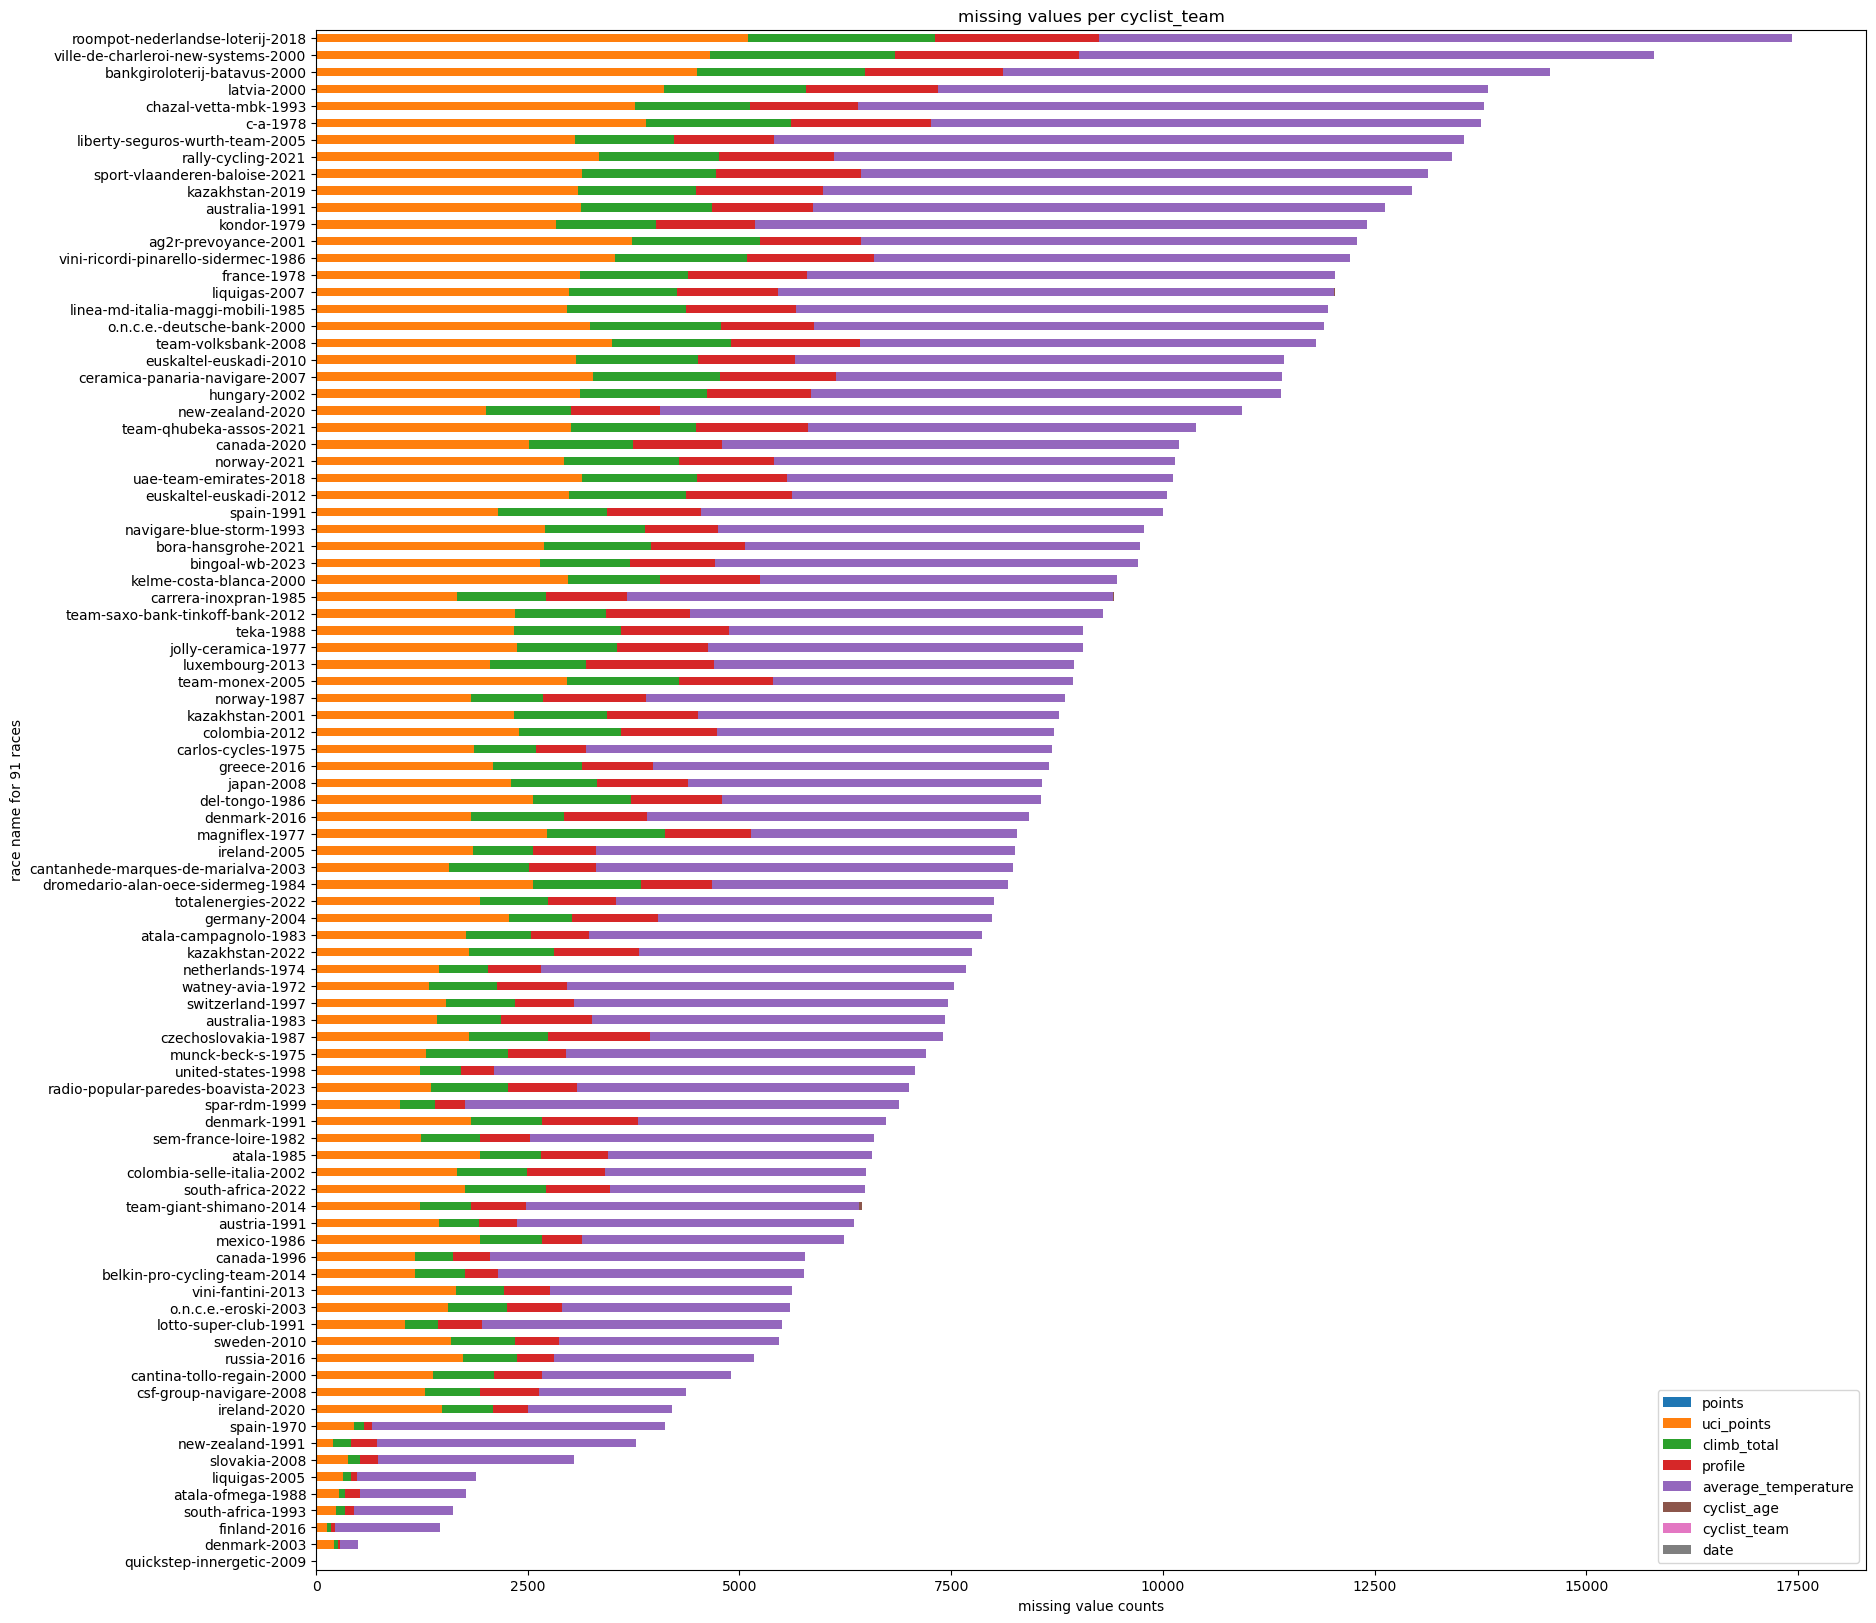

In [ ]:

utils.plot_cyclist_team_mv(races_df,mv_cols)

as we can from a quantitative perspective there is no clear trend for teams with missing values except for one with no missing values, it is difficult to observe any useful insight on the cyclists teams. We could narrow down the attributes to the ones of our interest and see if any useful insight pops out this time. For this reason we analise only the cyclist age which is related to the cyclists.

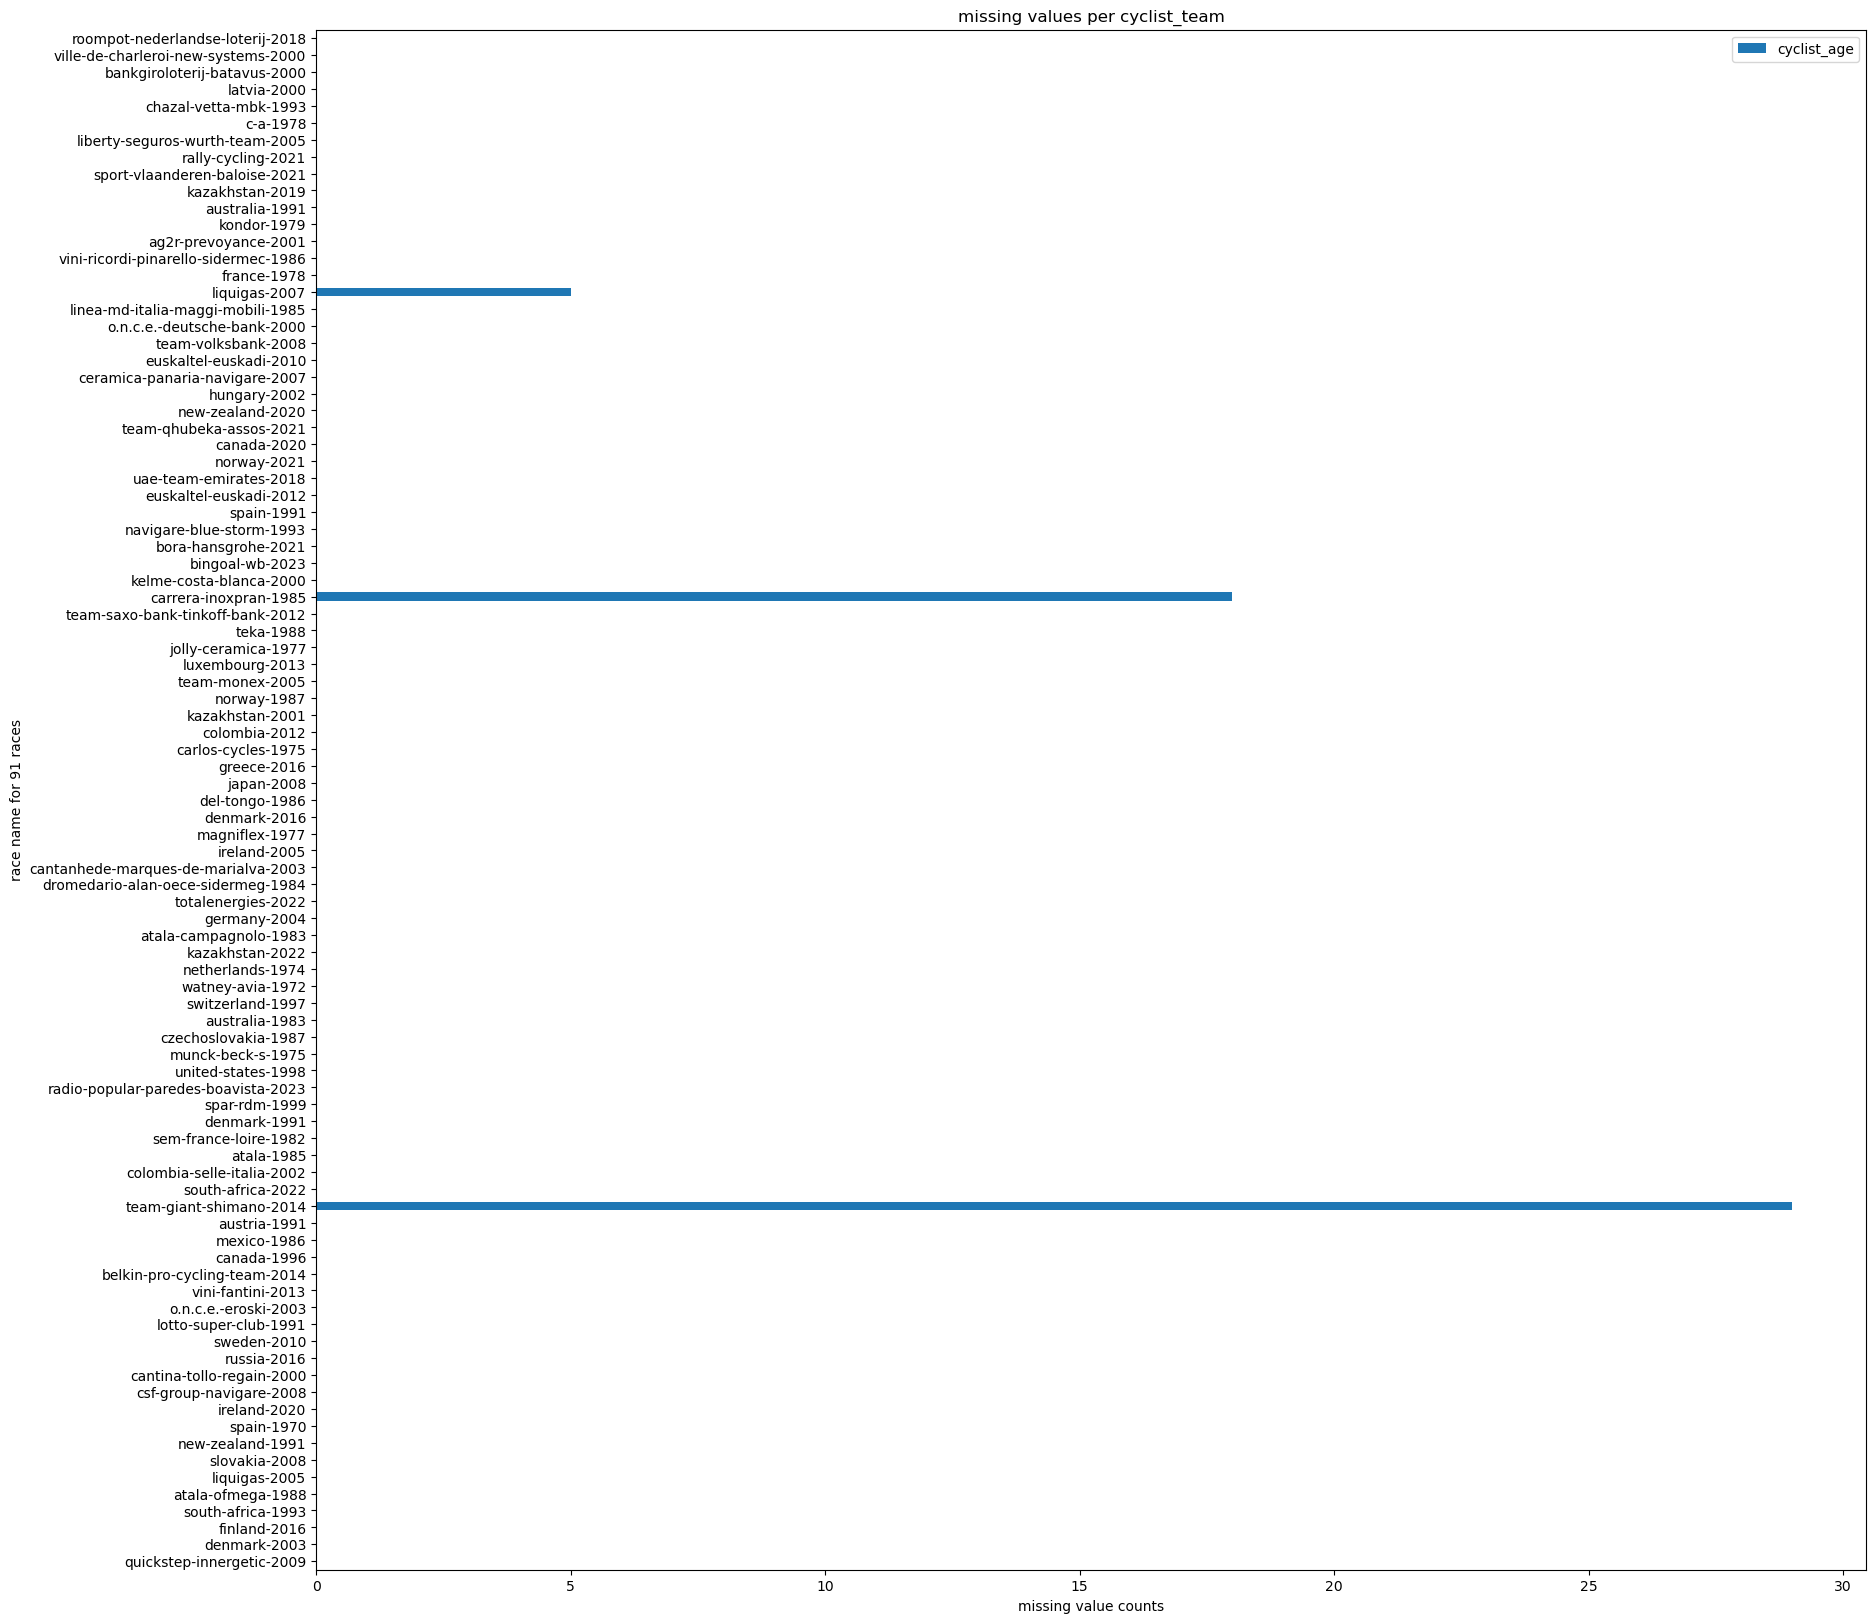

In [ ]:
utils.plot_cyclist_team_mv(races_df,['cyclist_age'])

Here we can actually gain useful insight observing how it seems that most missing values for the ages are concentrated within few teams actually. As for the usefulnes to our purpose we have top consider that this could derive from external reasons and is still a useful information to obtain.

# imputation

Given our previous observations we now proceed to fill in missing values using tbe facts we just discovered, also the dataset will be engineered by adding new features and removing/modifying the ones already present.

# cyclist_team

For the cyclist team it is difficult to infer teams without doing manual checking or referring to the internet for informations, a sensible idea would be to assign the unknown teams to the nationality of the country they come from.

In [ ]:
from os import path
import pandas as pd

CYCLIST_PATH=path.join('..','dataset','cyclists.csv')

cyclist_df=pd.read_csv(CYCLIST_PATH)

rec_races_df=races_df.copy()


In [ ]:

mt_idx=races_df['cyclist_team'].isna()

def map_to_team(row):
    return f"{row['nationality'].lower()}-{row['date'].year}"
plt.show()

rec_races_df.loc[mt_idx,'cyclist_team']=races_df[mt_idx].merge(cyclist_df,left_on='cyclist',right_on='_url')[['date','nationality']].apply(map_to_team,axis=1)

rec_races_df['cyclist_team'].fillna('free-agent',inplace=True)

rec_races_df['cyclist_team'].isna().sum()

/tmp/ipykernel_1055/3299179072.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rec_races_df['cyclist_team'].fillna('free-agent',inplace=True)


0

Now there are some useful considerations to make: first of all we see that the distribution doesn't get altered significantly so we can use it tom ake further analysis without having missing values, second some races do not allow solo racers but it depends on single races and their rules.


# profile

From the previous analysis the missing profile seems to be related to climb_total in some way, a sensed way of deducing the association between values and categories seems to be sing the climb_total and observe taht high total correspond to a profile that is probably mountainous and lower ones correspond to flat with all the in betweens.

After some a sensible mapping seems to be that the following bins are thee most suited for filling in the missing values:
- \(0,50\] is for flat 
- \(50,300\] is for hilly
- \(300,1000\] is for mountains
- \(1000,+\inf\] is for high mountains.

The reason comes from the minimum meters used to define a hill/mountain/high mountain

As for filling in the missing values, from the previous plot of the missing values per racesit seems reasonable to impute for each race the most probable values using mode for each race,year couple we have in the dataset as to maintain the profile.

In [ ]:
races_df_ext[['race_name','year']]=url_df[['name','year']]


def most_frequent(series):
    return series.mode()[0] if not series.mode().empty else np.nan

print(rec_races_df['profile'].value_counts(dropna=False))

rec_races_df['profile']= races_df_ext.groupby(['race_name','year'])['profile'].transform(
    most_frequent
)

rec_races_df['profile'].value_counts(dropna=False)
regression_df=races_df_ext

profile
NaN    148194
1.0    131344
2.0    128269
5.0     88203
3.0     50844
4.0     43011
Name: count, dtype: int64


After the first try it's not enough, we managed to succesfully impute roughly 12000 values so far which is useless for our considerations, by our code abaove we can infer another serious problem: profile is missing entirely for some races.

In [ ]:
#df=rec_races_df.sort_values(['race_name','year'])
rec_races_df[['race_name','year','stage']]=url_df[['name','year','stage']]
mp_df=rec_races_df.groupby(['race_name','year'])['profile'].apply(lambda x:x.isna().all())
mp_races=rec_races_df[['race_name','year']].drop_duplicates().loc[~mp_df.values,['race_name','year']]
mp_races

,race_name,year
4913,tirreno-adriatico,1999
5424,dauphine,1983
5429,la-fleche-wallone,2015
5562,vuelta-a-espana,2014
5756,giro-d-italia,2011
...,...,...
585859,milano-sanremo,1996
586221,amstel-gold-race,2013
588166,san-sebastian,2017
588250,gp-quebec,2010


In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler


def preprocess_dataset(df):
    #prep_df=df.copy()
    prep_df=pd.DataFrame(columns=[])
    
    scaler=StandardScaler()

    numeric_cols=df.select_dtypes('number').columns
    scaler.fit(df[numeric_cols])
    prep_df[numeric_cols]=scaler.fit_transform(df[numeric_cols])

    one_hot_encoder=OneHotEncoder(sparse_output=False)
    cat_cols=df.select_dtypes(['bool','object']).columns
    print(cat_cols)
    one_hot_encoder.fit(df[cat_cols])
    prep_df[one_hot_encoder.get_feature_names_out(cat_cols)]=one_hot_encoder.fit_transform(df[cat_cols])

    return prep_df
    


The most sensed way to try and reconstruct profile is to understand the logic behind it through machine learning algorithms and infer the missing values, our approach was a gradual one testing more and more complex algorithms until we reached good performances.

First and foremost we split the dataset in training and validation using stratified sampling to maintain the distribution on the development set. for profile we are dealing with a classification task hence we decided to use f1 score as overall matrix and observe the behavior of the various algorithms.

In [ ]:
import seaborn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder

rec_races_df['points']=rec_races_df['points'].mean()

print()

hm_df=preprocess_dataset(rec_races_df[['is_tarmac','race_name','points','length','stage']])
data=hm_df

#data['race_name']=cat_encoder.fit_transform(data[['race_name']])

train_set=data[~rec_races_df['profile'].isna()]
test_set=data[rec_races_df['profile'].isna()]

X_train_dev=train_set
Y_train_dev=rec_races_df.loc[~rec_races_df['profile'].isna(),'profile']

X_test=test_set
#Y_test=test_set['profile']

X_train,X_val,Y_train,Y_val=train_test_split(
        X_train_dev,Y_train_dev,
        test_size=0.2,
        stratify=Y_train_dev,
        random_state=42
    )


Index(['is_tarmac', 'race_name', 'stage'], dtype='object')


For all the expriments we decided to go with a micro averaged f1 score as a performance metric given the unbalanced distribution of the classes.

First we try a very simple model: the logistic regression, we se it as a baseline for performances given it's capabilities to capture non linear relationships.

In [ ]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sns

model = LinearRegression()
model=model.fit(X_train,Y_train)
Y_pred=model.predict(X_train)
Y_pred_output_train=np.digitize(Y_pred,bins=[0,1.5,2.5,3.5,4.5,5.5])
Y_pred=model.predict(X_val)
Y_pred_output_val=np.digitize(Y_pred,bins=[0,1.5,2.5,3.5,4.5,5.5])
print("f1 score on training set",f1_score(Y_train,Y_pred_output_train,average='micro'))
print("f1 score on validation set",f1_score(Y_val,Y_pred_output_val,average='micro'))


f1 score on training set 0.0008948331150354546
f1 score on validation set 0.0009145928368185719


Results are not satisfactory as we can see we are under 50%, given the large number of samples we decided to try a KNN and see if a different approach is more suitable.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

import itertools as it


hyper_params={
    'n_neighbors':[5,10,20],
    'distances':['euclidean','l1','cosine']
}
results=pd.DataFrame({
    'n_neighbors':[],
    'distances':[]
})
print(list(hyper_params.keys()))
values=list(it.product(*hyper_params.values()))
for n_neighbors,distance in values:
    model = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        metric=distance,
        n_jobs=-1
    )

    model.fit(X_train,Y_train)
    train_pred=model.predict(X_train)
    train_f1=f1_score(Y_train,train_pred,average='micro')

    val_pred=model.predict(X_val)
    val_f1=f1_score(Y_val,val_pred,average='micro')
    print('training set:',train_f1,'validation set:',val_f1,'params',(n_neighbors,distance))
    results = pd.concat([results, pd.DataFrame([{
        'n_neighbors':n_neighbors,
        'metric':distance,
        'training':train_f1,
        'validation':val_f1,
    }])], ignore_index=True)

['n_neighbors', 'distances']


In [ ]:
results.sort_values(by=['validation'],ascending=False)

As we can see we got a nice increase however validating and assessing the model is costly so after some trials we decided to try a random forest is better since he model is prone to be used with high dimensional datasets and thanks to it's use of ensambling should be able to avoid overfitting.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

import itertools as it


hyper_params={
    'n_estimators':[100,200,500],
    'max_depth':[10,20,30],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[2,5,10]
}
results=pd.DataFrame({
    'n_estimators':[],
    'max_depth':[],
    'min_samples_split':[],
    'training':[],
    'validation ':[],
})
print(list(hyper_params.keys()))
values=list(it.product(*hyper_params.values()))
for n_estimators,max_depth,min_samples_split,min_samples_leaf in values:
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        n_jobs=-1
    )

    model.fit(X_train,Y_train)
    train_pred=model.predict(X_train)
    train_f1=f1_score(Y_train,train_pred,average='micro')

    val_pred=model.predict(X_val)
    val_f1=f1_score(Y_val,val_pred,average='micro')
    print('training set:',train_f1,'validation set:',val_f1,'params',(n_estimators,max_depth,min_samples_split,min_samples_leaf))
    results = pd.concat(
        [results, 
        pd.DataFrame([{
            'n_estimators':n_estimators,
            'max_depth':max_depth,
            'min_samples_split':min_samples_split,
            'training':train_f1,
            'validation':val_f1,
        }])], 
    ignore_index=True)

['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']
training set: 0.6880715776850571 validation set: 0.6890808075251664 params (100, 10, 2, 2)
training set: 0.6912263427004458 validation set: 0.6917652236096595 params (100, 10, 2, 5)
training set: 0.6888004466729194 validation set: 0.689168821167281 params (100, 10, 2, 10)
training set: 0.6859894877838807 validation set: 0.6864844050827879 params (100, 10, 5, 2)
training set: 0.6840806761703848 validation set: 0.6849661697563122 params (100, 10, 5, 5)
training set: 0.6853293800212885 validation set: 0.6861873590406513 params (100, 10, 5, 10)
training set: 0.6855604177381958 validation set: 0.6864734033775235 params (100, 10, 10, 2)
training set: 0.6918011865437033 validation set: 0.6921942901149678 params (100, 10, 10, 5)
training set: 0.6867816170989914 validation set: 0.6874965619671048 params (100, 10, 10, 10)
training set: 0.9101675848582281 validation set: 0.9103581055063534 params (100, 20, 2, 2)
training set: 

In [ ]:
results.sort_values(by=['validation'],ascending=False)

,n_estimators,max_depth,min_samples_split,training,validation,validation
14,100.0,10,5.0,1.047120e+06,NaN,1.052221e+06
47,200.0,10,2.0,1.046231e+06,NaN,1.051412e+06
83,500.0,10,2.0,1.046053e+06,NaN,1.051233e+06
16,100.0,10,10.0,1.046032e+06,NaN,1.051178e+06
86,500.0,10,5.0,1.045913e+06,NaN,1.051123e+06
...,...,...,...,...,...,...
75,500.0,None,5.0,3.950706e+04,NaN,3.972693e+04
36,200.0,None,2.0,3.950759e+04,NaN,3.972566e+04
39,200.0,None,5.0,3.950737e+04,NaN,3.972518e+04
0,100.0,None,2.0,3.950843e+04,NaN,3.971825e+04


Ultimately random forest seem to be a better choice since we get good performances and have trouble with a thorough validation using KNN given it's time consuming nature, also we can plot the ranom forest decision tree and try to gain more insights on our dataset.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

n_estimators,max_depth,min_samples_split,min_samples_leaf=values[results['validation'].argmax()]

rfc=RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    n_jobs=-1
    )
rfc=rfc.fit(X_train_dev,Y_train_dev)
Y_test=rfc.predict(X_test)
rec_races_df.loc[rec_races_df['profile'].isna(),'profile']=Y_test

: 

<Axes: >

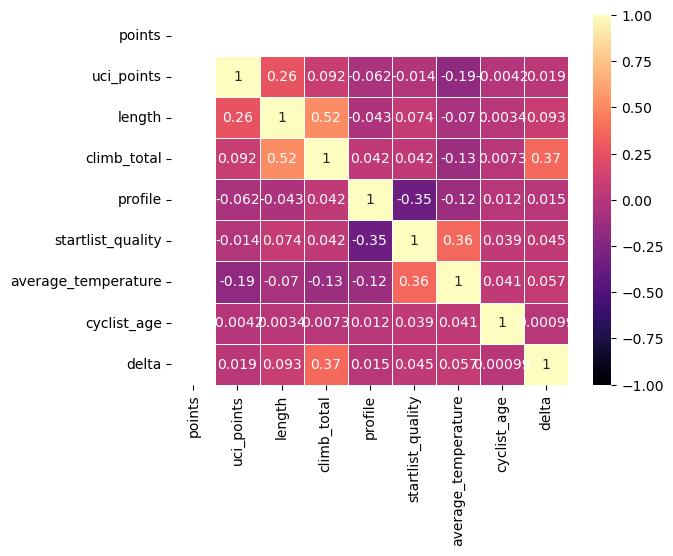

In [ ]:
import seaborn as sns

rec_races_df.isnull().sum()

sns.heatmap(rec_races_df[["points","uci_points", "length", "climb_total", "profile", "startlist_quality", "average_temperature", "cyclist_age", "delta"]].corr()
            , annot=True, cmap='magma', vmin=-1, vmax=1, linewidths=0.5)

# cyclist_age


In [ ]:
rec_races_df.loc[rec_races_df['cyclist_age'].isna(),'cyclist_age']=rec_races_df['cyclist_age'].mean()

# points


In [ ]:
rec_races_df.loc[rec_races_df['points'].isna(),'points']=rec_races_df['points'].mean()

# climb total

Also climb total need to be filled and presents the same issue, we don't have any way actually reconstruct it without using external sources so we apply the same strategy for imputation by doing a regression task, in this case the evaluation metric is the MSE .

In [ ]:
from sklearn.metrics import mean_squared_error
data=preprocess_dataset(rec_races_df[['is_tarmac','race_name','points','length','stage']])
train_set=data[~rec_races_df['climb_total'].isna()]
test_set=data[rec_races_df['climb_total'].isna()]

X_train_dev=train_set
Y_train_dev=rec_races_df.loc[~rec_races_df['climb_total'].isna(),'climb_total']

X_test=test_set


X_train,X_val,Y_train,Y_val=train_test_split(X_train_dev,Y_train_dev,test_size=0.2,random_state=42)


Index(['is_tarmac', 'race_name', 'stage'], dtype='object')


In [ ]:
from sklearn.linear_model import LinearRegression


model = LinearRegression()
model=model.fit(X_train,Y_train)
Y_pred_output_train=model.predict(X_train)

Y_pred_output_val=model.predict(X_val)

print("mse score on training set",mean_squared_error(Y_train,Y_pred_output_train))
print("mse score on validation set",mean_squared_error(Y_val,Y_pred_output_val))
Y_test_output=model.predict(X_test)

mse score on training set 1079539.4990721752
mse score on validation set 1088224.4467941262


Of course a linear model cannot yield successful results, as for the profile we will try both KNN and random forests as before.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

import itertools as it


hyper_params={
    'n_neighbors':[5,10,20],
    'distances':['euclidean','l1','cosine']
}
results=pd.DataFrame({
    'n_neighbors':[],
    'distances':[]
})
print(list(hyper_params.keys()))
values=list(it.product(*hyper_params.values()))
for n_neighbors,distance in values:
    model = KNeighborsRegressor(
        n_neighbors=n_neighbors,
        metric=distance,
        n_jobs=-1
    )

    model.fit(X_train,Y_train)
    train_pred=model.predict(X_train)
    train_mse=mean_squared_error(Y_train,train_pred)

    val_pred=model.predict(X_val)
    val_mse=mean_squared_error(Y_val,val_pred)
    print('training set:',train_mse,'validation set:',val_mse,'params',(n_neighbors,distance))
    results = pd.concat([results, pd.DataFrame([{
        'n_neighbors':n_neighbors,
        'metric':distance,
        'training':train_mse,
        'validation':val_mse,
    }])], ignore_index=True)

['n_neighbors', 'distances']
training set: 48200.43339065535 validation set: 47271.78067657287 params (5, 'euclidean')
training set: 48090.650903866124 validation set: 47225.93645815455 params (5, 'l1')


: 

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

import itertools as it

hyper_params={
    'n_estimators':[100,200,500],
    'max_depth':[None,10,20,30],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[2,5,10]
}
results=pd.DataFrame({
    'n_estimators':[],
    'max_depth':[],
    'min_samples_split':[],
    'training':[],
    'validation ':[],
})
print(list(hyper_params.keys()))
values=list(it.product(*hyper_params.values()))
for n_estimators,max_depth,min_samples_split,min_samples_leaf in values:
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        n_jobs=-1
    )

    model.fit(X_train,Y_train)
    train_pred=model.predict(X_train)
    train_mse=mean_squared_error(Y_train,train_pred)

    val_pred=model.predict(X_val)
    val_mse=mean_squared_error(Y_val,val_pred)
    print('training set:',train_mse,'validation set:',val_mse,'params',(n_estimators,max_depth,min_samples_split,min_samples_leaf))
    results = pd.concat(
        [results, 
        pd.DataFrame([{
            'n_estimators':n_estimators,
            'max_depth':max_depth,
            'min_samples_split':min_samples_split,
            'training':train_mse,
            'validation':val_mse,
        }])], 
    ignore_index=True)

['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']
training set: 39508.429990281526 validation set: 39718.25238526143 params (100, None, 2, 2)
training set: 39910.98995219117 validation set: 40342.934667920854 params (100, None, 2, 5)
training set: 42642.99556068566 validation set: 42731.854152351974 params (100, None, 2, 10)
training set: 39507.79007454828 validation set: 39712.910709240445 params (100, None, 5, 2)
training set: 39910.81690376426 validation set: 40330.294713081625 params (100, None, 5, 5)
training set: 42642.50942970059 validation set: 42708.68533282783 params (100, None, 5, 10)
training set: 39515.48724601138 validation set: 39748.037669148005 params (100, None, 10, 2)
training set: 39912.29879846144 validation set: 40346.95375131134 params (100, None, 10, 5)
training set: 42563.39518055605 validation set: 42678.07997789201 params (100, None, 10, 10)
training set: 1044739.482802859 validation set: 1049696.0509138796 params (100, 10, 2, 2)
training

KeyboardInterrupt: 

# values reconstruction
The most missing value to be used in the dataset is clearly the average temperature, to solve this issue we came up with a strategy that involves gathering external data in our dataset.

After som thorough research we've came up with the website procyclingstats and an API that can scrape data from it.

Note: there are many alternatives much more complete and suitable for this,however they also have time limits for requests or costly monthly plans so we resorted to this to keep down time and avoid any kind of expense.

In [ ]:
RACES_PATH="./races_api_data.json"
GEODATA_PATH='./geodata.csv'

Due to the time needed to gather data we saved all the fathered that in a json file to work with it later, the code below uses the API to gather data from the website regarding the stages since it's what we need and then saves every information in a json file.

In [ ]:
from os import path
if not path.exists(RACES_PATH):
    utils.fetch_from_procyclingstas(races_df,RACES_PATH)

AttributeError: module 'utils' has no attribute 'fetch_from_procyclingstas'

First we load in a dataframe the relevant data, in this case we take the names of the the arrival and departure places for each stage, this information is not present in the dataset and therefore was retrieved using the API in the code above.

In [ ]:
import json
import pandas as pd

with open(RACES_PATH,'r') as f:
    data=json.load(f)

stages_df=pd.DataFrame([{
                    'url':stage['url'],
                    'departure':stage['departure'],
                    'arrival':stage['arrival'],
                } 
              for stage in data])
stages_df

FileNotFoundError: [Errno 2] No such file or directory: './races_api_data.json'

from the retrieved values we can take advantage of aecond api to get geocoordinates of any place,further enriching the information we gather.

In [ ]:
from geopy.geocoders import Nominatim

places_info=utils.map_place_to_point(stages_df,Nominatim(user_agent="Mirko"))

ModuleNotFoundError: No module named 'geopy'

we load the obatined info into a dataframe and save the results for later usage.

In [ ]:
geo_df=pd.DataFrame([{
    'name':info.raw['name'],
    'altitude':info.altitude,
    'longitude':info.longitude,
    'latitude':info.latitude
}for info in places_info])

geo_df.to_csv(GEODATA_PATH)

geo_df

NameError: name 'places_info' is not defined

Finaly we can associate the given information we gathered into a single dataframe

In [ ]:
geo_df=pd.read_csv(GEODATA_PATH)

temp_df=stages_df.merge(right=geo_df,left_on='departure',right_on='name')
temp_df=temp_df.merge(right=geo_df,left_on='arrival',right_on='name',suffixes=('_arr',''))
temp_df=temp_df.drop(columns=['name','name_arr']).drop_duplicates()
temp_df

FileNotFoundError: [Errno 2] No such file or directory: './geodata.csv'

using the geospatial data we can reconstruct the average temperatuer using the meteostat API to gain access to historical data about the weather,including the temperature.

In [ ]:
from meteostat import Point,Hourly,Daily
from datetime import datetime

race_stage_df=races_df.groupby('_url')

race_stage_df=race_stage_df.agg('first').drop(columns='average_temperature')

arr_temp_df=temp_df[['arrival','altitude_arr','longitude_arr','latitude_arr']]

def fetch_temp(df_row):
    point=Point(df_row['latitude'],df_row['longitude'])
    dt=df_row['date'].to_pydatetime()

    hourly=Daily(point,start=dt,end=dt)
    data=hourly.fetch()
    if not data.empty:
        print(data)

data=pd.merge(left=race_stage_df[['date']],
              left_on=race_stage_df.index,
              right=temp_df,
              right_on=temp_df.index
              )
data.apply(fetch_temp,axis=1)

ModuleNotFoundError: No module named 'meteostat'

However the API demonstrated to be incomplete,difficult to use andvery imprecise at least during our efforts, so we decided given the time and resoruces limit to stop going down this path.

Some further enhance could be obtained by switch to paid services,like Strava, or manually searching some other sources of geospatial data.

In [ ]:
from os import path
import json
import pandas as pd

with open(path.join('.','races_api_data.json'),'r') as f:
    races_api_data=json.load(f)

df=pd.DataFrame([
    {
        '_url':data['url'],
        'climb_total':data['vertical_meters'],
    }
    for data in races_api_data
])

In [ ]:
len(races_df[races_df['climb_total'].isna()].merge(df[df['climb_total'].notna()],left_on='_url',right_on='_url',how='inner'))

131

Unfortunately even dough a model selection was provided even the best performing model did not manage to maintain correaltions dfespite good performances during the classification tasks, given the time constraint we decided that further inverstigations we're not useful and resorted to a much simple and effective method of imputation for profile and climb_total.

In [ ]:
from sklearn.impute import SimpleImputer
import pandas as pd

# Crea una copia dei dati rilevanti per l'imputazione
df_for_imputation = rec_races_df[['climb_total', 'profile']].copy()

# Imputa i valori mancanti nella colonna 'climb_total' usando la media
imputer_climb = SimpleImputer(strategy='mean')
df_for_imputation['climb_total'] = imputer_climb.fit_transform(df_for_imputation[['climb_total']])

# Calcola la media di 'climb_total' per ogni 'profile'
profile_mean_climb_total = df_for_imputation.groupby('profile')['climb_total'].mean()
reference_df = profile_mean_climb_total.reset_index()
reference_df.columns = ['profile', 'mean_climb_total']

# Funzione per riempire i valori mancanti nella colonna 'profile' con il profilo più vicino
def fill_profile_with_closest(row):
    if pd.isna(row['profile']):
        closest_profile = reference_df.iloc[(reference_df['mean_climb_total'] - row['climb_total']).abs().argsort()[:1]]
        return closest_profile['profile'].values[0]
    return row['profile']

# Applica la funzione per imputare i valori mancanti di 'profile'
df_for_imputation['profile'] = df_for_imputation.apply(fill_profile_with_closest, axis=1)

# Aggiorna i dati originali con i valori imputati
rec_races_df[['climb_total', 'profile']] = df_for_imputation

# Stampa i valori NaN rimanenti (dovrebbero essere 0 se l'imputazione è completa)
print("NaN after the imputation:")
print(rec_races_df[['climb_total', 'profile']].isnull().sum())

NaN after the imputation:
climb_total    0
profile        0
dtype: int64


<Axes: >

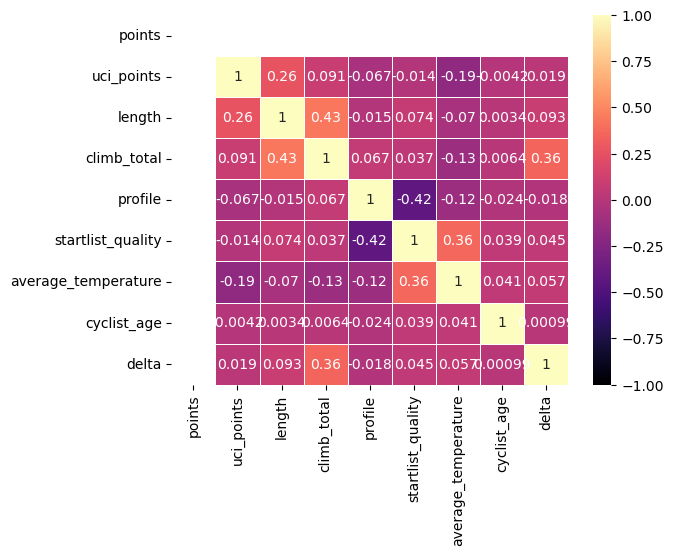

In [ ]:
sns.heatmap(rec_races_df[["points","uci_points", "length", "climb_total", "profile", "startlist_quality", "average_temperature", "cyclist_age", "delta"]].corr()
            , annot=True, cmap='magma', vmin=-1, vmax=1, linewidths=0.5)

So after imputing we need to handle some features that are not usefulfor our analysis:
- average temperature is dropped since it is missing for 94% of the dataset and imputation of any kind would be uselesss also we did not successfully managed to reconstruct it using scraping or external data of any kind
- uci_points are not missing much however we have that the same semantic meaning can be found in points which have a very high correlation, thus to avoid redundancy  we decided to evict this feature.
- for the is_X featrures we observed that fact that  is_cobbled and is_gravel are always false, hence thery are not informative at all for our purposes to avoid useless features we decided to keep only is_tarmac and delete is_cobbled and is_gravel.

In [ ]:
from os import path
CLEANED_DATA_PATH=path.join('races_cleaned.csv')

final_df=rec_races_df.drop(columns=['uci_points','average_temperature','is_cobbled','is_gravel']).to_csv(CLEANED_DATA_PATH)



Note: this is a notebook that contains the whole analysis and process that broguht us to maniopulating the dataset, for practical reasons a function that does the same thing in a more streamlined way is included in the utils.py file.

In [ ]:
import utils

cleaned_races=utils.handle_missing_df(races_df,cyclist_df)



/home/mirdan08/DataMiningProject/src/task1_data_understanding/utils.py:236: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rec_races_df['cyclist_team'].fillna('free-agent',inplace=True)
